# Multimodal Algorithm for Misinformation Detection

Implementing a proof of concept (PoC) for a multimodal algorithm for misinformation detection requires integrating multiple data sources (text, images, videos, etc.) and leveraging AI/ML techniques to analyze and classify misinformation. 

Text Data: https://huggingface.co/datasets/ErfanMoosaviMonazzah/fake-news-detection-dataset-English

Image Data: 

Video Data: 

**Install dependencies**

In [ ]:
#%pip install opencv-python-headless
#%conda install -c numba numba
#%conda install -c conda-forge librosa
#%pip install -U datasets huggingface_hub fsspec
#%pip install torchaudio
#%pip install librosa
# pip uninstall torch torchvision transformers
# pip install torch torchvision
# pip install transformers

# 1. Data Collection & Preprocessing 

## Text Analysis: Using transformer model (BERT) for fake news detection.

### Explore FakeNewsNet Dataset

**The FakeNewsNet dataset includes fake and real news articles along with metadata such as user engagement and network interactions.**

In [ ]:
from datasets import load_dataset
import pandas as pd

# Load FakeNewsNet dataset from Hugging Face
dataset = load_dataset("ErfanMoosaviMonazzah/fake-news-detection-dataset-English")

# Convert dataset to Pandas DataFrame
df = pd.DataFrame(dataset['train'])

# Display sample
print(df.head())

print("\nFakeNewsNet dataset explored successfully!")

In [ ]:
# Plot histogram of the number of words in the train data 'title'
import matplotlib.pyplot as plt
seq_len = [len(i.split()) for i in df['title']]
pd.Series(seq_len).hist(bins = 40,color='firebrick')
plt.xlabel('Number of words')
plt.ylabel('Number of texts')
plt.title('Histogram of Words')
plt.show()

In [ ]:
# Check data imbalance
label_size = df.groupby('label').size()
print(label_size)

plt.pie(label_size, explode=[0.1,0.1], colors=['firebrick','blue'], startangle=90,labels=['Fake News', 'Real News'], shadow=True, autopct='%1.1f%%')
plt.title('Data Imbalance')
plt.show()

## Text Data Preprocessing (BERT Tokenization)

### How This Works

✔ Loads FakeNewsNet dataset

✔ Preprocesses text with BERT tokenization

✔ Creates PyTorch Dataloader for batch processing

✔ Fine-tunes BERT for Fake News classification

✔ Trains & evaluates the model with accuracy metrics

This imports BERT's tokenizer from the Hugging Face transformers library

bert-base-uncased is a pre-trained BERT model that treats text as lowercase (e.g., "Hello" and "hello" are treated the same)

Tokenize a sample data to what it looks like.

In [ ]:
import torch
import pandas as pd
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from transformers import BertTokenizer, BertForSequenceClassification
from datasets import load_dataset

# Load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

def preprocess_text(texts):
    """
    Tokenize a batch of texts with BERT.
    
    Args:
    texts (list of str): List of text samples to tokenize.
    
    Returns:
    dict: Dictionary containing input_ids, attention_mask, and token_type_ids.
    """
    encoded_inputs = tokenizer(
        texts,
        padding="max_length",  # Pad to max_length for batch consistency
        truncation=True,       # Truncate texts longer than 20 tokens
        max_length=15,        # BERT max token limit
        return_tensors="pt"    # Return PyTorch tensors
    )
    
    return {
        "input_ids": encoded_inputs["input_ids"],
        "attention_mask": encoded_inputs["attention_mask"],
        "token_type_ids": encoded_inputs["token_type_ids"]
    }

# Example usage with a batch of texts
sample_text = ["Fake news detection using multimodal learning.",
               "Using Bert."]

# Tokenize and print results
tokenized_output = preprocess_text(sample_text)
print(tokenized_output)


## Training

In [ ]:
import torch
from datasets import load_dataset
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_scheduler
from torch.utils.data import DataLoader
import torch.nn.functional as F
from tqdm import tqdm
import os

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Load dataset from Hugging Face
dataset = load_dataset("ErfanMoosaviMonazzah/fake-news-detection-dataset-English")

# Select all the rows in training dataset
train_data = dataset["train"]
test_data = dataset["test"]
val_data = dataset["validation"]

# Load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Function to tokenize text
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=20)

# Tokenize datasets
train_data = train_data.map(tokenize_function, batched=True)
test_data = test_data.map(tokenize_function, batched=True)
val_data = val_data.map(tokenize_function, batched=True)

# Convert labels to tensor format
def format_dataset(data):
    return data.with_format("torch", columns=["input_ids", "attention_mask", "label"])

train_data = format_dataset(train_data)
test_data = format_dataset(test_data)
val_data = format_dataset(val_data)

# Create DataLoaders
train_dataloader = DataLoader(train_data, batch_size=8, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=8)
val_dataloader = DataLoader(val_data, batch_size=8)

# Load BERT model with classification head
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
model.to(device)

# Define optimizer
optimizer = optim.AdamW(model.parameters(), lr=2e-5)

# Define learning rate scheduler
num_training_steps = len(train_dataloader) * 3  # 3 epochs
lr_scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

# Define the loss functions
criterion = torch.nn.CrossEntropyLoss()

# Save model directory
best_model_path = "best_bert_fake_news_detector"
os.makedirs(best_model_path, exist_ok=True)

# Initialize best accuracy tracking
best_val_accuracy = 0.0

# Evaluation function
def evaluate_model(dataloader, split_name):
    model.eval()
    total, correct = 0, 0
    with torch.no_grad():
        for batch in tqdm(dataloader, desc=f"Evaluating on {split_name}"):
            batch = {
                "input_ids": batch["input_ids"].to(device),
                "attention_mask": batch["attention_mask"].to(device),
                "labels": batch["label"].to(device),  # Rename 'label' to 'labels'
            }
            outputs = model(**batch)
            predictions = torch.argmax(outputs.logits, dim=-1)
            correct += (predictions == batch["labels"]).sum().item()
            total += batch["labels"].size(0)
    accuracy = correct / total
    print(f"📊 {split_name} Accuracy: {accuracy:.4f}")
    return accuracy


# Training loop with best model saving

num_epochs = 3
print("\n🚀 Training Started...")
for epoch in range(num_epochs):
    model.train()
    loop = tqdm(train_dataloader, leave=True)
    
    for batch in loop:
        batch = {
            "input_ids": batch["input_ids"].to(device),
            "attention_mask": batch["attention_mask"].to(device),
            "labels": batch["label"].to(device),  # Rename 'label' to 'labels'
        }
        
        outputs = model(**batch)  # No error now
        loss = criterion(outputs.logits, batch["labels"])

        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

        loop.set_description(f"Epoch {epoch+1}")
        loop.set_postfix(loss=loss.item())

    # Evaluate after each epoch
    val_accuracy = evaluate_model(val_dataloader, "Validation")

    # Save the model if validation accuracy improves
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        model.save_pretrained(best_model_path)
        tokenizer.save_pretrained(best_model_path)
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_accuracy': best_val_accuracy
        }, os.path.join(best_model_path, "best_text_model.pth"))
        print(f"✅ Best model saved with Validation Accuracy: {val_accuracy:.4f}")

print("✅ Training Completed!")


# Load the best model for evaluation
print("\n🔄 Loading the best model...")
best_model = BertForSequenceClassification.from_pretrained(best_model_path)
best_tokenizer = BertTokenizer.from_pretrained(best_model_path)
best_model.to(device)
print("✅ Best model loaded successfully!")




## Evaluation

In [ ]:
# Evaluate on test set
evaluate_model(test_dataloader, "Test")

**After training, you can load the model and make predictions**

## Model Performance

In [ ]:
from sklearn.metrics import classification_report
import torch
from tqdm import tqdm

def classification_report_test(model, dataloader):
    model.eval()  # Set model to evaluation mode
    all_preds, all_labels = [], []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating on Test Set"):
            batch = {
                "input_ids": batch["input_ids"].to(device),
                "attention_mask": batch["attention_mask"].to(device),
                "labels": batch["label"].to(device),  # Ensure correct label key
            }
            outputs = model(**batch)
            predictions = torch.argmax(outputs.logits, dim=-1)

            all_preds.extend(predictions.cpu().numpy())  # Convert to NumPy for sklearn
            all_labels.extend(batch["labels"].cpu().numpy())

    # Generate classification report
    report = classification_report(all_labels, all_preds, target_names=["Real", "Fake"])
    print("\n📊 Classification Report on Test Set:\n")
    print(report)

classification_report_test(model, test_dataloader)


Interpretation:

* Precision: How many of the predicted "Fake" news are actually fake?

* Recall: How many actual "Fake" news were correctly identified?

* F1-score: The harmonic mean of precision & recall.

* Support: Number of test samples in each class.


***

# Image Analysis: Using ViTs for detecting manipulated images.

### Import Required Libraries

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import torchvision.models as models
import os
from transformers import AutoImageProcessor, AutoModelForImageClassification
from datasets import load_dataset
from PIL import Image
import numpy as np
from tqdm import tqdm
import gc
import json
import psutil
import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'


# # First, create a directory to save models if it doesn't exist
# save_dir = 'image_model_checkpoints'

### Prepare to Load the Image Manipulation Dataset

In [ ]:
# Initialize image processor
image_processor = AutoImageProcessor.from_pretrained(
    "google/vit-base-patch16-224",
    use_fast=True
)

# Disable PIL's size limit
Image.MAX_IMAGE_PIXELS = None

def print_memory_usage():
    """Monitor memory usage"""
    process = psutil.Process(os.getpid())
    print(f"Memory usage: {process.memory_info().rss / 1024 / 1024:.2f} MB")

def preprocess_image(image, max_size=1024):
    """Process a single image with size limiting"""
    try:
        # Ensure image is in RGB format
        if image.mode != 'RGB':
            image = image.convert('RGB')
        
        # Get image dimensions
        width, height = image.size
        
        # Resize if the image is too large
        if width > max_size or height > max_size:
            aspect_ratio = width / height
            if width > height:
                new_width = max_size
                new_height = int(max_size / aspect_ratio)
            else:
                new_height = max_size
                new_width = int(max_size * aspect_ratio)
            image = image.resize((new_width, new_height), Image.Resampling.LANCZOS)
        
        # Process the image
        processed = image_processor(image, return_tensors="pt")
        return processed.pixel_values[0]
    except Exception as e:
        print(f"Error processing image: {e}")
        return None

class StreamingImageDataset(Dataset):
    def __init__(self, dataset_split, buffer_size=1000):
        """
        Initialize the dataset with a buffer to store samples
        Args:
            dataset_split: The dataset split (train or test)
            buffer_size: Number of samples to keep in memory
        """
        self.dataset = dataset_split
        self.buffer_size = buffer_size
        self.buffer = []
        self.current_index = 0
        
        # Fill initial buffer
        self._fill_buffer()
    
    def _fill_buffer(self):
        """Fill the buffer with processed images"""
        print("Filling data buffer...")
        self.buffer = []
        
        for i, item in enumerate(self.dataset.take(self.buffer_size)):
            processed_image = preprocess_image(item['image'])
            if processed_image is not None:
                self.buffer.append((processed_image, item['label']))
            
            if (i + 1) % 100 == 0:
                print(f"Processed {i + 1} images")
                print_memory_usage()
        
        print(f"Buffer filled with {len(self.buffer)} images")
    
    def __len__(self):
        return len(self.buffer)
    
    def __getitem__(self, idx):
        return self.buffer[idx]

def create_data_loaders(batch_size=32, buffer_size=1000):
    """Create data loaders with streaming datasets"""
    print("Loading dataset...")
    
    try:
        # Load dataset
        dataset = load_dataset("date3k2/raw_real_fake_images", streaming=True)
        
        # Create streaming datasets
        train_dataset = StreamingImageDataset(dataset['train'], buffer_size=buffer_size)
        test_dataset = StreamingImageDataset(dataset['test'], buffer_size=buffer_size)
        
        print(f"Train dataset size: {len(train_dataset)}")
        print(f"Test dataset size: {len(test_dataset)}")
        
        # Create data loaders
        train_loader = DataLoader(
            train_dataset,
            batch_size=batch_size,
            shuffle=True,
            num_workers=2,
            pin_memory=True
        )
        
        test_loader = DataLoader(
            test_dataset,
            batch_size=batch_size,
            shuffle=False,
            num_workers=2,
            pin_memory=True
        )
        
        return train_loader, test_loader
    
    except Exception as e:
        print(f"Error creating data loaders: {e}")
        raise

def train_model(model, train_loader, test_loader, num_epochs=3, save_dir='image_model_results'):
    """Train the model with checkpointing and monitoring"""
    os.makedirs(save_dir, exist_ok=True)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Initialize optimizer and criterion
    optimizer = optim.Adam(model.parameters(), lr=2e-5)
    criterion = nn.CrossEntropyLoss()
    
    best_accuracy = 0.0
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct, total = 0, 0
        
        # Training loop with progress bar
        progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')
        for batch_idx, (images, labels) in enumerate(progress_bar):
            print_memory_usage()  # Monitor memory usage
            
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(pixel_values=images)
            loss = criterion(outputs.logits, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.logits, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            
            # Update progress bar
            progress_bar.set_postfix({
                'loss': f'{running_loss/(batch_idx+1):.4f}',
                'accuracy': f'{correct/total:.4f}'
            })
            
            # Clear some memory
            del outputs, loss
            gc.collect()
        
        # Calculate epoch metrics
        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = correct / total
        
        # Evaluate on test set
        test_accuracy = evaluate_model(model, test_loader, device)
        
        # Save checkpoint if best model
        if test_accuracy > best_accuracy:
            best_accuracy = test_accuracy
            checkpoint = {
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'accuracy': test_accuracy,
            }
            torch.save(checkpoint, os.path.join(save_dir, 'best_image_model.pth'))
            print(f"✅ New best model saved with accuracy: {test_accuracy:.4f}")
        
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Training Loss: {epoch_loss:.4f}, Training Accuracy: {epoch_accuracy:.4f}")
        print(f"Test Accuracy: {test_accuracy:.4f}")
        print("-" * 50)

def evaluate_model(model, dataloader, device):
    """Evaluate the model"""
    model.eval()
    correct, total = 0, 0
    
    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc='Evaluating'):
            images, labels = images.to(device), labels.to(device)
            outputs = model(pixel_values=images)
            _, predicted = torch.max(outputs.logits, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            
            # Clear some memory
            del outputs
            gc.collect()
    
    accuracy = correct / total
    return accuracy
    
print("✅ Prepared to Load Data and Train Model!")

### Train and Evaluate the Image Model

In [ ]:
if __name__ == "__main__":
    # Configuration
    BATCH_SIZE = 16
    BUFFER_SIZE = 1000  # Adjust based on your available memory
    NUM_EPOCHS = 3
    SAVE_DIR = 'image_model_results'
    
    try:
        # Create data loaders
        print("Initializing data loaders...")
        train_loader, test_loader = create_data_loaders(
            batch_size=BATCH_SIZE,
            buffer_size=BUFFER_SIZE
        )
        print("✅ DataLoaders Ready!")
        
        # Initialize model
        print("Loading Pretrained Vision Transformer (ViT) Model...")
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model = AutoModelForImageClassification.from_pretrained(
            "google/vit-base-patch16-224",
            num_labels=2,
            ignore_mismatched_sizes=True
        )
        model.to(device)
        print("✅ Vision Transformer (ViT) Model Loaded!")
        
        # Train model
        train_model(
            model=model,
            train_loader=train_loader,
            test_loader=test_loader,
            num_epochs=NUM_EPOCHS,
            save_dir=SAVE_DIR
        )
        
        # Final evaluation
        print("\nPerforming final evaluation...")
        final_accuracy = evaluate_model(model, test_loader, device)
        print(f"Final Test Accuracy: {final_accuracy:.4f}")
        
    except Exception as e:
        print(f"Error occurred: {str(e)}")
        raise

**Evaluating Learning Curve Rate**

In [ ]:
from transformers import AutoModelForImageClassification
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix
from tqdm import tqdm
import os


def train_and_evaluate(model, train_loader, test_loader, learning_rates, device, num_epochs=10):
    """
    Train and evaluate model across different learning rates
    """
    results = {}
    
    for lr in learning_rates:
        print(f"\nTraining with learning rate: {lr}")
        
        # Reset model or create new instance
        model.apply(lambda m: m.reset_parameters() if hasattr(m, 'reset_parameters') else None)
        
        # Initialize optimizer and criterion
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        criterion = torch.nn.CrossEntropyLoss()
        
        # Training loop
        model.train()
        for epoch in range(num_epochs):
            running_loss = 0.0
            for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
                images, labels = batch
                images = images.to(device)
                labels = labels.to(device)
                
                # Zero the parameter gradients
                optimizer.zero_grad()
                
                # Forward pass - note we need to access .logits
                outputs = model(images).logits
                
                # Calculate loss
                loss = criterion(outputs, labels)
                
                # Backward pass and optimize
                loss.backward()
                optimizer.step()
                
                running_loss += loss.item()
            
            # Print epoch statistics
            epoch_loss = running_loss / len(train_loader)
            print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")
        
        # Evaluate and store results
        print(f"\nEvaluating model with learning rate {lr}")
        results[lr] = evaluate_model_performance(model, test_loader, device)
    
    # Plot comparison
    plot_learning_rate_comparison(results)
    
    return results

def evaluate_model_performance(model, test_loader, device):
    """
    Evaluate model performance with comprehensive metrics
    """
    model.eval()
    all_preds = []
    all_labels = []
    all_pred_probs = []
    
    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Evaluating"):
            images, labels = batch
            images = images.to(device)
            labels = labels.to(device)
            
            # Get model outputs - note the .logits attribute
            outputs = model(images).logits
            
            # Apply softmax to get probabilities
            pred_probs = torch.softmax(outputs, dim=1)
            predicted = torch.argmax(outputs, dim=1)
            
            # Store predictions and labels
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_pred_probs.extend(pred_probs[:, 1].cpu().numpy())
    
    # Convert to numpy arrays
    y_pred = np.array(all_preds)
    y_true = np.array(all_labels)
    y_pred_prob = np.array(all_pred_probs)
    
    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    
    # Calculate ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    
    # Print metrics
    print("\nModel Performance Metrics:")
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"AUC Score: {roc_auc:.4f}")
    
    # Create visualizations
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # 1. Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1)
    ax1.set_title('Confusion Matrix')
    ax1.set_ylabel('True Label')
    ax1.set_xlabel('Predicted Label')
    
    # 2. ROC Curve
    ax2.plot(fpr, tpr, color='darkorange', lw=2, 
             label=f'ROC curve (AUC = {roc_auc:.2f})')
    ax2.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax2.set_xlim([0.0, 1.0])
    ax2.set_ylim([0.0, 1.05])
    ax2.set_xlabel('False Positive Rate')
    ax2.set_ylabel('True Positive Rate')
    ax2.set_title('ROC Curve')
    ax2.legend(loc="lower right")
    
    plt.tight_layout()
    plt.show()
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc': roc_auc,
        'confusion_matrix': cm
    }

def plot_learning_rate_comparison(results_dict):
    """
    Plot performance comparison across different learning rates
    
    Parameters:
    results_dict: dictionary with learning rates as keys and performance metrics as values
    """
    learning_rates = list(results_dict.keys())
    metrics = ['accuracy', 'precision', 'recall', 'f1', 'auc']
    
    plt.figure(figsize=(12, 6))
    for metric in metrics:
        values = [results_dict[lr][metric] for lr in learning_rates]
        plt.semilogx(learning_rates, values, 'o-', label=metric.capitalize())
    
    plt.grid(True)
    plt.xlabel('Learning Rate')
    plt.ylabel('Score')
    plt.title('Model Performance Metrics vs Learning Rate')
    plt.legend()
    plt.show()

# Example usage
def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    try:
        # Initialize model
        model = AutoModelForImageClassification.from_pretrained(
            "google/vit-base-patch16-224",
            num_labels=2,
            ignore_mismatched_sizes=True
        ).to(device)
        
        # Define learning rates to try
        learning_rates = [2e-5, 1e-5, 1e-4, 1e-3, 1e-2]
        
        # Train and evaluate
        results = train_and_evaluate(
            model=model,
            train_loader=train_loader,
            test_loader=test_loader,
            learning_rates=learning_rates,
            device=device,
            num_epochs=3
        )
        
        # Print best results
        best_lr = max(results.keys(), key=lambda x: results[x]['accuracy'])
        print(f"\nBest learning rate: {best_lr}")
        print("====Best model performance metrics====")
        print(f"Accuracy: {results[best_lr]['accuracy']:.4f}")
        print(f"Precision: {results[best_lr]['precision']:.4f}")
        print(f"Recall: {results[best_lr]['recall']:.4f}")
        print(f"F1 Score: {results[best_lr]['f1']:.4f}")
        print(f"AUC Score: {results[best_lr]['auc']:.4f}")
        
    except Exception as e:
        print(f"Error during training and evaluation: {e}")
        raise

if __name__ == "__main__":
    main()

print("Learning rate Evaluation Completed!")

### Performance of the Image Model

In [ ]:
from transformers import AutoModelForImageClassification
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix
from tqdm import tqdm

def collect_predictions(model, test_loader, device):
    """
    Collect predictions and labels from the model
    """
    model.eval()
    all_preds = []
    all_labels = []
    all_pred_probs = []
    
    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Collecting predictions"):
            images, labels = batch
            images = images.to(device)
            labels = labels.to(device)
            
            # Get model outputs - note the .logits attribute
            outputs = model(images).logits
            
            # Apply softmax to get probabilities
            pred_probs = torch.softmax(outputs, dim=1)
            predicted = torch.argmax(outputs, dim=1)
            
            # Store predictions and labels
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_pred_probs.extend(pred_probs[:, 1].cpu().numpy())
            
    return np.array(all_preds), np.array(all_labels), np.array(all_pred_probs)

def evaluate_model_performance(model, test_loader, device):
    """
    Evaluate model performance with comprehensive metrics
    """
    # Collect predictions
    y_pred, y_true, y_pred_prob = collect_predictions(model, test_loader, device)
    
    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    
    # Calculate ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    
    # Print metrics
    print("\nModel Performance Metrics:")
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"AUC Score: {roc_auc:.4f}")
    
    # Create visualizations
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # 1. Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1)
    ax1.set_title('Confusion Matrix')
    ax1.set_ylabel('True Label')
    ax1.set_xlabel('Predicted Label')
    
    # 2. ROC Curve
    ax2.plot(fpr, tpr, color='darkorange', lw=2, 
             label=f'ROC curve (AUC = {roc_auc:.2f})')
    ax2.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax2.set_xlim([0.0, 1.0])
    ax2.set_ylim([0.0, 1.05])
    ax2.set_xlabel('False Positive Rate')
    ax2.set_ylabel('True Positive Rate')
    ax2.set_title('ROC Curve')
    ax2.legend(loc="lower right")
    
    plt.tight_layout()
    plt.show()
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc': roc_auc,
        'confusion_matrix': cm
    }

def main():
    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    try:
        # Initialize the model
        model = AutoModelForImageClassification.from_pretrained(
            "google/vit-base-patch16-224",
            num_labels=2,
            ignore_mismatched_sizes=True
        )
        
        # Load the best saved model
        checkpoint_path = os.path.join('image_model_results', 'best_image_model.pth')
        checkpoint = torch.load(checkpoint_path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        model.to(device)
        model.eval()
        
        print("\nEvaluating model performance...")
        results = evaluate_model_performance(model, test_loader, device)
        
        # Print detailed results
        print("\nDetailed Performance Metrics:")
        print(f"Accuracy: {results['accuracy']:.4f}")
        print(f"Precision: {results['precision']:.4f}")
        print(f"Recall: {results['recall']:.4f}")
        print(f"F1 Score: {results['f1']:.4f}")
        print(f"AUC Score: {results['auc']:.4f}")
        
    except Exception as e:
        print(f"Error in evaluation: {e}")
        raise

if __name__ == "__main__":
    main()


***

# Implementation for Audio Analysis (LSTM)

### Load and Split Audio dataset

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchaudio.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from datasets import load_dataset
from tqdm import tqdm
import numpy as np


from datasets import load_dataset
from sklearn.model_selection import train_test_split
import numpy as np

# Load the entire training dataset
full_dataset = load_dataset("012shin/fake-audio-detection-augmented2", split="train")

print(f"Total samples in full dataset: {len(full_dataset)}")

# Convert the dataset to a format suitable for splitting
dataset_dict = full_dataset.to_dict()
indices = list(range(len(full_dataset)))

# Perform stratified split to maintain class distribution
train_indices, test_indices = train_test_split(
    indices,
    test_size=0.2,
    random_state=42,
    stratify=[item for item in full_dataset['label']]
)

# Create the train and test datasets
train_data = full_dataset.select(train_indices)
test_data = full_dataset.select(test_indices)

print("\nDataset Split Results:")
print(f"Training samples: {len(train_data)}")
print(f"Testing samples: {len(test_data)}")

# Verify class distribution in both splits
def print_class_distribution(dataset, name=""):
    labels = [item for item in dataset['label']]
    unique_labels, counts = np.unique(labels, return_counts=True)
    print(f"\n{name} Split Distribution:")
    print("----------------------------")
    for label, count in zip(unique_labels, counts):
        percentage = (count/len(dataset))*100
        print(f"Label {label}: {count} samples ({percentage:.2f}%)")

# Print distributions
print_class_distribution(train_data, "Training")
print_class_distribution(test_data, "Testing")

# Optional: Save the splits for future use
train_data.save_to_disk('train_split')
test_data.save_to_disk('test_split')

# Verify data structure
print("\nSample data structure:")
print("----------------------")
sample = train_data[0]
for key, value in sample.items():
    print(f"{key}: {type(value)}")


### Load Audio Dataset from disk

In [ ]:
from datasets import load_from_disk

# Load the saved splits
train_data = load_from_disk('train_split')
test_data = load_from_disk('test_split')

### Explore Audio Dataset

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np



def analyze_class_distribution(data, split_name=""):
    # First, let's examine the structure of a single item
    first_item = data[0]
    print(f"\nFirst item label structure: {first_item['label']}")
    
    # Convert dataset to a list of labels
    # If labels are lists, take the first element
    labels = []
    for item in data:
        if isinstance(item['label'], list):
            labels.append(item['label'][0])  # Take first element if it's a list
        else:
            labels.append(item['label'])
            
    # Convert to numpy array
    labels = np.array(labels)
    
    # Count unique labels
    unique_labels, counts = np.unique(labels, return_counts=True)
    label_counts = pd.Series(counts, index=unique_labels)
    
    # Calculate percentages
    total_samples = len(labels)
    label_percentages = (label_counts / total_samples * 100).round(2)
    
    # Print distribution
    print(f"\n{split_name} Split Distribution:")
    print("----------------------------")
    for label, count in label_counts.items():
        percentage = label_percentages[label]
        print(f"Label {label}: {count} samples ({percentage}%)")
    
    # Create pie chart
    plt.figure(figsize=(8, 6))
    plt.pie(label_counts, labels=[f'Label {i}' for i in label_counts.index], 
            autopct='%1.1f%%', startangle=90,
            colors=['lightblue', 'lightgreen'])
    plt.title(f'Class Distribution - {split_name} Split')
    plt.axis('equal')
    plt.show()
    
    # Calculate imbalance ratio
    if len(label_counts) > 1:
        imbalance_ratio = label_counts.max() / label_counts.min()
        print(f"\nImbalance Ratio: {imbalance_ratio:.2f}")
        if imbalance_ratio > 1.5:
            print("⚠️ Dataset is imbalanced (ratio > 1.5)")
    
    return label_counts

# Basic dataset info
print("Dataset Overview:")
print(f"Training Samples: {len(train_data)}")
print(f"Testing Samples: {len(test_data)}")

# Analyze training data
train_distribution = analyze_class_distribution(train_data, "Training")

# Analyze test data
test_distribution = analyze_class_distribution(test_data, "Test")

# Compare distributions between train and test
plt.figure(figsize=(10, 5))
train_props = train_distribution / len(train_data)
test_props = test_distribution / len(test_data)

bar_width = 0.35
index = range(len(train_props))

plt.bar(index, train_props, bar_width, label='Train', color='lightblue')
plt.bar([i + bar_width for i in index], test_props, bar_width, label='Test', color='lightgreen')

plt.xlabel('Labels')
plt.ylabel('Proportion')
plt.title('Class Distribution Comparison - Train vs Test')
plt.xticks([i + bar_width/2 for i in index], [f'Label {i}' for i in train_props.index])
plt.legend()
plt.show()

# Print sample data structure
print("\nSample Data Structure:")
print("----------------------")
sample_item = train_data[0]
for key, value in sample_item.items():
    print(f"{key}: {type(value)} - {value}")

In [ ]:
import torch
import torchaudio.transforms as transforms

# Define transformation: Convert audio to Mel Spectrogram
mel_transform = transforms.MelSpectrogram(
    sample_rate=16000, n_mels=64, n_fft=1024, hop_length=512
)

# Define a fixed spectrogram length (128 frames)
FIXED_SPEC_LENGTH = 128

# Function to preprocess audio
def preprocess(example):
    waveform = example["audio"]["array"]  # Extract waveform
    waveform = torch.tensor(waveform, dtype=torch.float32).unsqueeze(0)  # Convert to float32 & add batch dimension
    
    mel_spec = mel_transform(waveform)  # Convert to Mel spectrogram

    # Pad or truncate to fixed length
    if mel_spec.shape[2] < FIXED_SPEC_LENGTH:
        pad_amount = FIXED_SPEC_LENGTH - mel_spec.shape[2]
        mel_spec = torch.nn.functional.pad(mel_spec, (0, pad_amount))  # Pad along time dimension
    else:
        mel_spec = mel_spec[:, :, :FIXED_SPEC_LENGTH]  # Truncate

    example["mel_spectrogram"] = mel_spec.squeeze(0)  # Remove batch dimension
    return example

# Apply preprocessing
train_data = train_data.map(preprocess)
test_data = test_data.map(preprocess)

Create Dataloaders

In [ ]:
from torch.utils.data import DataLoader

def collate_fn(batch):
    # First convert each mel_spectrogram to a tensor
    mel_specs = [torch.FloatTensor(item["mel_spectrogram"]) for item in batch]
    mel_specs = torch.stack(mel_specs)
    
    # Convert labels to class indices (not one-hot)
    # If your labels are already one-hot encoded, convert them to indices
    labels = [torch.argmax(torch.tensor(item["label"])) if isinstance(item["label"], (list, np.ndarray)) 
             else item["label"] for item in batch]
    labels = torch.tensor(labels, dtype=torch.long)
    
    return mel_specs, labels


# Create DataLoaders
train_loader = DataLoader(train_data, batch_size=8, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_data, batch_size=8, collate_fn=collate_fn)

print("✅ DataLoaders Ready!")

In [ ]:
# Define LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, input_dim=64, hidden_dim=128, num_layers=2, num_classes=2):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        # Initialize hidden state and cell state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        
        x = x.permute(0, 2, 1)  # Reshape for LSTM (batch, seq, feature)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])  # Take last timestep output
        return out

### Train & Save The Best Audio Model

In [ ]:
# Training loop

# Define model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training loop with best model saving
num_epochs = 5
best_accuracy = 0.0


for epoch in range(num_epochs):
    running_loss = 0.0
    correct, total = 0, 0

    model.train()
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        mel_specs, labels = batch
        # Move tensors to device
        mel_specs = mel_specs.to(device)
        labels = labels.to(device)  # Now labels should be 1D tensor of indices

        # Reshape if needed
        if len(mel_specs.shape) == 2:
            mel_specs = mel_specs.unsqueeze(1)

        optimizer.zero_grad()
        
        try:
            outputs = model(mel_specs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            
        except Exception as e:
            print(f"Error during training: {str(e)}")
            print(f"mel_specs shape: {mel_specs.shape}")
            print(f"labels shape: {labels.shape}")
            print(f"labels dtype: {labels.dtype}")
            print(f"outputs shape: {outputs.shape if 'outputs' in locals() else 'N/A'}")
            print(f"outputs dtype: {outputs.dtype if 'outputs' in locals() else 'N/A'}")
            raise e

    epoch_loss = running_loss / len(train_loader)
    accuracy = correct / total
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.4f}")

    # Save best model
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': epoch_loss,
            'accuracy': accuracy
        }, "best_lstm_fake_audio.pth")
        print("📁 Best model saved!")

print("✅ Training Complete!")

### Evaluation and Performance of the Audio Model

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_model(model, dataloader, device):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    try:
        with torch.no_grad():
            for mel_specs, labels in tqdm(dataloader, desc="Evaluating"):
                # Move data to device
                mel_specs = mel_specs.to(device)
                labels = labels.to(device)
                
                # Forward pass
                outputs = model(mel_specs)
                _, predicted = torch.max(outputs, 1)
                
                # Collect predictions and labels
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                
                # Calculate running accuracy
                correct += (predicted == labels).sum().item()
                total += labels.size(0)
                
        # Calculate metrics
        accuracy = correct / total
        
        # Convert to numpy arrays for sklearn metrics
        all_preds = np.array(all_preds)
        all_labels = np.array(all_labels)
        
        # Calculate additional metrics
        precision = precision_score(all_labels, all_preds, average='weighted')
        recall = recall_score(all_labels, all_preds, average='weighted')
        f1 = f1_score(all_labels, all_preds, average='weighted')
        
        # Create confusion matrix
        cm = confusion_matrix(all_labels, all_preds)
        
        # Print results
        print("\n=== Model Evaluation Results ===")
        print(f"📊 Test Accuracy: {accuracy:.4f}")
        print(f"📊 Precision: {precision:.4f}")
        print(f"📊 Recall: {recall:.4f}")
        print(f"📊 F1 Score: {f1:.4f}")
        print("\n=== Confusion Matrix ===")
        print(cm)
        
        return {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'confusion_matrix': cm,
            'predictions': all_preds,
            'true_labels': all_labels
        }
        
    except Exception as e:
        print(f"Error during evaluation: {str(e)}")
        print(f"Last batch shapes - mel_specs: {mel_specs.shape}, labels: {labels.shape}")
        raise e

# Load and evaluate the model
try:
    # Load the best model
    checkpoint = torch.load("best_lstm_fake_audio.pth")
    if isinstance(checkpoint, dict):
        model.load_state_dict(checkpoint['model_state_dict'])
        print(f"Loaded model from epoch {checkpoint['epoch']} with training accuracy: {checkpoint['accuracy']:.4f}")
    else:
        model.load_state_dict(checkpoint)
    
    # Make sure model is on the correct device
    model = model.to(device)
    
    # Evaluate
    results = evaluate_model(model, test_loader, device)
    
    # Optional: Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(results['confusion_matrix'], annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
except Exception as e:
    print(f"Error loading or evaluating model: {str(e)}")


# 2. Model Selection & Implementation

## Text Classification (Fake News Detection with BERT)

In [ ]:
from transformers import BertForSequenceClassification, BertTokenizer

# Load trained model and tokenizer
print("\n🔄 Loading the best model...")
tokenizer = BertTokenizer.from_pretrained(best_model_path)
text_model = BertForSequenceClassification.from_pretrained(best_model_path)
text_model.to(device)
text_model.eval()
print("✅ Best model loaded successfully!")


# Predict function
def predict(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512).to(device)
    with torch.no_grad():
        outputs = text_model(**inputs)
    predicted_class = torch.argmax(outputs.logits).item()
    return "Fake News" if predicted_class == 0 else "Real News"

# Test prediction
text = "Can you blame her for losing her cool with Crooked Lying Hillary? Share this with all of your  undecided  friends!https://youtu.be/CCkXOix0g2Y" # Fake News
print("Prediction:", predict(text))

text = "These people will support just about anything Obama says scary stuff!" # Fake News
print("Prediction:", predict(text))

text = "Two people were shot dead on Friday as Kenyan police tried to disperse opposition supporters marching from an airport alongside the convoy of opposition leader Raila Odinga, a Reuters witness said." # Real News
print("Prediction:", predict(text))

text = "The North Korean issue should be resolved peacefully through talks, Chinese President Xi Jinping told British Prime Minister Theresa May in a telephone call, state radio said on Monday." # Real News
print("Prediction:", predict(text)) 

***

## Image Classification (ViT-based Fake Image Detection)

In [ ]:
import torch
import torch.nn as nn
from transformers import ViTForImageClassification
from torchvision import transforms
from PIL import Image
import os
from collections import OrderedDict


# Initialize the model
print("\n🔄 Loading the best model...")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize ViT model
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')
# Modify the classifier for binary classification (Fake/Real)
model.classifier = nn.Linear(model.config.hidden_size, 2)

# Load the checkpoint
save_dir = 'image_model_results'
best_model_path = os.path.join(save_dir, 'best_image_model.pth')
checkpoint = torch.load(best_model_path, map_location=device, weights_only=True)

# Load state dict
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
model.eval()

def predict_image(image_tensor, model):
    """
    Make prediction on a single image
    """
    image_tensor = image_tensor.unsqueeze(0).to(device)
    
    with torch.no_grad():
        outputs = model(image_tensor).logits
        probabilities = torch.softmax(outputs, dim=1)
        confidence, predicted = torch.max(probabilities, dim=1)
        
        return predicted.item(), confidence.item()

def load_and_preprocess_image(image_path):
    """
    Load and preprocess a specific image for prediction
    """
    try:
        # ViT specific transformations
        transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5],
                              std=[0.5, 0.5, 0.5])
        ])
        
        # Load and transform image
        image = Image.open(image_path).convert('RGB')
        image_tensor = transform(image)
        
        print(f"✅ Successfully loaded image: {image_path}")
        return image_tensor.to(device)
    
    except Exception as e:
        print(f"❌ Error loading image: {str(e)}")
        return None

# Test specific image
print("\n🔄 Making prediction on fake_news_image.jpeg...")
image_path = 'fake_news_image.jpeg'

if os.path.exists(image_path):
    # Load and preprocess the image
    test_tensor = load_and_preprocess_image(image_path)
    
    if test_tensor is not None:
        # Make prediction
        prediction, confidence = predict_image(test_tensor, model)
        
        # Print results
        print("\nResults:")
        print(f"Image: {image_path}")
        print(f"Prediction: {'Fake' if prediction == 0 else 'Real'}")
        print(f"Confidence: {confidence:.2%}")
    else:
        print("❌ Failed to process the image.")
else:
    print(f"❌ Image not found: {image_path}")


***

## Multimodal Fusion Model

In [14]:
from transformers import BertForSequenceClassification, BertTokenizer
from torchvision import models
import torch
import torch.nn as nn
from transformers import ViTForImageClassification
from torchvision import transforms
from PIL import Image
import os
from collections import OrderedDict


# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 🔹 Load Text Model (BERT)
class FakeTextDetector(nn.Module):
    def __init__(self, model_path="best_bert_fake_news_detector"):
        super(FakeTextDetector, self).__init__()

        # Load BERT model & tokenizer
        self.model = BertForSequenceClassification.from_pretrained(model_path)
        self.tokenizer = BertTokenizer.from_pretrained(model_path)

        # Load additional checkpoint if exists
        checkpoint_path = os.path.join(model_path, "best_text_model.pth")
        if os.path.exists(checkpoint_path):
            checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=True)
            self.model.load_state_dict(checkpoint["model_state_dict"])
            print(f"✅ Loaded trained text model from {model_path}")
        else:
            print("⚠️ Warning: Text model checkpoint not found!")

        self.model.to(device)

    # def forward(self, text_inputs):
    #     return self.model(**text_inputs).logits

    def forward(self, text_inputs):
        # Modified forward method to handle the input dictionary
        outputs = self.model(
            input_ids=text_inputs['input_ids'],
            attention_mask=text_inputs.get('attention_mask', None),
            token_type_ids=text_inputs.get('token_type_ids', None)
        )
        return outputs.logits


# 🔹 Load Image Model (ViT)
class FakeImageDetector(nn.Module):
    def __init__(self, save_dir='image_model_results', model_name='best_image_model.pth'):
        super(FakeImageDetector, self).__init__()

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        # Initialize transformations
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5],
                              std=[0.5, 0.5, 0.5])
        ])

        
        # Initialize the ViT model
        self.vit = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')
        # Modify classifier for binary classification (Fake/Real)
        self.vit.classifier = nn.Linear(self.vit.config.hidden_size, 2)
        
        # Setup model path
        self.model_path = os.path.join(save_dir, model_name)
        
        # Load trained model
        try:
            if os.path.exists(self.model_path):
                checkpoint = torch.load(self.model_path, map_location=device, weights_only=True)
                state_dict = checkpoint['model_state_dict']
                
                print(f"✅ Loaded trained ViT model from {self.model_path}")    
            else:
                print(f"⚠️ Warning: ViT model checkpoint not found at {self.model_path}")
                print("Model will be initialized with random weights.")
        except Exception as e:
            print(f"❌ Error loading model: {str(e)}")
            print("Model will be initialized with random weights.")
            
        # Move model to device
        self.to(device)
        self.eval()  # Set to evaluation mode by default

    def forward(self, x):
        """
        Forward pass that returns logits for fusion model
        """
        if len(x.shape) != 4:
            raise ValueError(f"Expected 4D tensor with shape [batch_size, channels, height, width], got shape {x.shape}")
        if x.shape[1] != 3:
            raise ValueError(f"Expected 3 channels, got {x.shape[1]}")        
        outputs = self.vit(x)
        return outputs.logits

    def predict(self, image_tensor):
        """
        Standalone prediction method with confidence scores
        """
        self.eval()
        with torch.no_grad():
            outputs = self(image_tensor)
            probabilities = torch.softmax(outputs, dim=1)
            confidence, predicted = torch.max(probabilities, dim=1)
            return predicted.item(), confidence.item()




# 🔹 Load Audio Model (LSTM)
class FakeAudioDetector(nn.Module):
    def __init__(self, audio_model_path="best_lstm_fake_audio.pth", input_size=64, hidden_size=128, num_layers=2):
        super(FakeAudioDetector, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 2)  # Ensure output has 2 neurons (Fake/Real)

        # Load trained model
        if os.path.exists(audio_model_path):
            checkpoint = torch.load(audio_model_path, weights_only=True, map_location=torch.device("cuda" if torch.cuda.is_available() else "cpu"))
            
            if "model_state_dict" in checkpoint:  # Ensure compatibility
                self.load_state_dict(checkpoint["model_state_dict"])
                print(f"✅ Loaded trained audio model from {audio_model_path}")
            else:
                self.load_state_dict(checkpoint)
                print("⚠️ Warning: Model loaded without additional metadata.")

        else:
            print("⚠️ Warning: Audio model checkpoint not found!")

        self.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

    def forward(self, x):
        _, (hidden, _) = self.lstm(x)
        return self.fc(hidden[-1])



# 🔹 Multimodal Fake News Detector (Combining Text, Image & Audio)
class MultimodalFakeNewsDetector(nn.Module):
    def __init__(self):
        super(MultimodalFakeNewsDetector, self).__init__()

        # Load individual models
        self.text_model = FakeTextDetector()
        self.image_model = FakeImageDetector()
        self.audio_model = FakeAudioDetector()

        # Fusion Layer (Combining all 3 modal features)
        self.fc = nn.Linear(2 + 2 + 2, 2)  # Final classification

    def forward(self, text_inputs, image_inputs, audio_inputs):
        text_features = self.text_model(text_inputs)  # BERT output
        image_features = self.image_model(image_inputs)  # ResNet output
        audio_features = self.audio_model(audio_inputs)  # LSTM output

        fused_features = torch.cat((text_features, image_features, audio_features), dim=1)
        return self.fc(fused_features)


# 🔹 Load the multimodal model
multimodal_model = MultimodalFakeNewsDetector()
multimodal_model.eval()  # Set to evaluation mode




✅ Loaded trained text model from best_bert_fake_news_detector
✅ Loaded trained ViT model from image_model_results/best_image_model.pth
✅ Loaded trained audio model from best_lstm_fake_audio.pth


MultimodalFakeNewsDetector(
  (text_model): FakeTextDetector(
    (model): BertForSequenceClassification(
      (bert): BertModel(
        (embeddings): BertEmbeddings(
          (word_embeddings): Embedding(30522, 768, padding_idx=0)
          (position_embeddings): Embedding(512, 768)
          (token_type_embeddings): Embedding(2, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): BertEncoder(
          (layer): ModuleList(
            (0-11): 12 x BertLayer(
              (attention): BertAttention(
                (self): BertSdpaSelfAttention(
                  (query): Linear(in_features=768, out_features=768, bias=True)
                  (key): Linear(in_features=768, out_features=768, bias=True)
                  (value): Linear(in_features=768, out_features=768, bias=True)
                  (dropout): Dropout(p=0.1, inplace=False)
                )
                (o

# 3. Multimodal Model Training & Optimization

### Dataset for the multimodal model

In [15]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from datasets import load_dataset
from PIL import Image
import torchaudio
import torch.nn as nn
from sklearn.metrics import roc_curve, auc, confusion_matrix, recall_score, f1_score, precision_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
from torchvision import transforms
from timm import create_model
import os

def check_model_files():
    model_files = [
        'best_bert_fake_news_detector/best_text_model.pth',
        'image_model_results/best_image_model.pth',
        'best_lstm_fake_audio.pth'
    ]
    
    for file_path in model_files:
        if not os.path.isfile(file_path):
            print(f"Warning: {file_path} not found")
        else:
            print(f"Found: {file_path}")

# inspect model files
check_model_files()


def inspect_audio_dataset():
    print("Inspecting audio dataset structure...")
    audio_data = load_dataset("012shin/fake-audio-detection-augmented", split='train')
    
    # Get first item
    first_item = audio_data[0]
    print("\nKeys in first audio item:", first_item.keys())
    print("\nSample audio item structure:", first_item)
    
    return first_item.keys()

# inspect audio dataset
audio_keys = inspect_audio_dataset()
print(f"\nAvailable audio keys: {audio_keys}")


class MultimodalDataset(Dataset):
    def __init__(self, split='train'):
        self.tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
        
        print(f"Loading {split} datasets...")
        
        try:
            # Load datasets from Hugging Face
            print("Loading text dataset...")
            self.text_data = load_dataset("BeardedJohn/FakeNews", split=split)
            # self.text_data = load_dataset("ErfanMoosaviMonazzah/fake-news-detection-dataset-English", split=split)
            
            print("Loading image dataset...")
            self.image_data = load_dataset("itsLeen/deepfake_vs_real_image_detection", split=split)
            # self.image_data = load_dataset("date3k2/raw_real_fake_images", split=split)
            
            print("Loading audio dataset...")
            self.audio_data = load_dataset("012shin/fake-audio-detection-augmented", split=split)
            # self.audio_data = load_dataset("012shin/fake-audio-detection-augmented2", split=split)
            
            print("All datasets loaded successfully!")
        except Exception as e:
            print(f"Error loading datasets: {str(e)}")
            raise
        
        # Define transforms
        self.image_transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def __len__(self):
        return min(len(self.text_data), len(self.image_data), len(self.audio_data))

    @staticmethod
    def ensure_batch_dimension(tensor, expected_shape):
        """
        Ensures tensor has batch dimension and correct shape
        """
        if tensor.dim() == len(expected_shape):
            # Add batch dimension if missing
            tensor = tensor.unsqueeze(0)
        
        current_shape = tuple(tensor.shape[1:])  # Shape without batch dimension
        if current_shape != expected_shape:
            raise ValueError(f"Expected shape {expected_shape}, got {current_shape}")
        
        return tensor


    def __getitem__(self, idx):
        try:
            # Process text
            text = self.text_data[idx]['text']
            text_encoding = self.tokenizer(
                text,
                padding='max_length',
                truncation=True,
                max_length=512,
                return_tensors='pt'
            )
            
            # Process image
            try:
                # Get image data
                image_data = self.image_data[idx]['image']
                
                # Convert to PIL Image if it's not already
                if isinstance(image_data, dict) and 'bytes' in image_data:
                    image = Image.open(io.BytesIO(image_data['bytes'])).convert('RGB')
                elif isinstance(image_data, str):
                    # If it's a file path
                    image = Image.open(image_data).convert('RGB')
                elif isinstance(image_data, Image.Image):
                    image = image_data.convert('RGB')
                else:
                    # If it's raw bytes
                    image = Image.open(io.BytesIO(image_data)).convert('RGB')
                
                image_tensor = self.image_transform(image)
                image_tensor = MultimodalDataset.ensure_batch_dimension(image_tensor, (3, 224, 224))
                # print("Final image tensor shape:", image_tensor.shape)
                
            except Exception as e:
                print(f"Error processing image at index {idx}: {str(e)}")
                image_tensor = torch.zeros(1, 3, 224, 224)  # Include batch dimension


            # Process audio
            try:
                # Extract features from raw audio
                audio_data = self.audio_data[idx]['audio']
                audio_array = torch.tensor(audio_data['array'])
                
                # Generate features from the audio array
                audio_features = self.extract_audio_features(audio_array)
                
                # Ensure correct dimensions using ensure_batch_dimension
                audio_features = MultimodalDataset.ensure_batch_dimension(audio_features, (64,))
                # print("Audio features shape:", audio_features.shape)
                
            except Exception as e:
                print(f"Error processing audio at index {idx}: {str(e)}")
                audio_features = torch.zeros(1, 64)  # Create fallback with batch dimension
                        
            
            # Get labels
            label = torch.tensor(self.text_data[idx]['label'])
            
            # Squeeze any extra dimensions from the text encoding
            text_encoding = {k: v.squeeze(0) for k, v in text_encoding.items()}
            
            return {
                'text': text_encoding,
                'image': image_tensor,
                'audio': audio_features,
                'label': label
            }
            
        except Exception as e:
            print(f"Error processing item {idx}: {str(e)}")
            raise

    def inspect_item(self, idx):
        """Debug method to inspect raw data at a specific index"""
        print("\nInspecting raw data at index", idx)
        print("\nText data:", self.text_data[idx])
        print("\nImage data:", self.image_data[idx])
        print("\nAudio data:", self.audio_data[idx])


    def extract_audio_features(self, audio_array):
        """
        Extract features from raw audio array
        You can choose one of these methods or combine them
        """
        try:
            # Option 1: Simple statistical features
            features = []
            chunk_size = len(audio_array) // 64  # Divide audio into 64 chunks
            
            for i in range(0, len(audio_array), chunk_size):
                chunk = audio_array[i:i + chunk_size]
                features.append(chunk.mean())
            
            features = torch.tensor(features)
            
            # Ensure we have exactly 64 features
            if len(features) < 64:
                features = F.pad(features, (0, 64 - len(features)))
            elif len(features) > 64:
                features = features[:64]
                
            return features
            
        except Exception as e:
            print(f"Error in feature extraction: {str(e)}")
            return torch.zeros(64)




Found: best_bert_fake_news_detector/best_text_model.pth
Found: image_model_results/best_image_model.pth
Found: best_lstm_fake_audio.pth
Inspecting audio dataset structure...

Keys in first audio item: dict_keys(['id', 'audio', 'label'])

Sample audio item structure: {'id': 'RUNQPNJF', 'audio': {'path': 'RUNQPNJF.ogg', 'array': array([0., 0., 0., ..., 0., 0., 0.]), 'sampling_rate': 16000}, 'label': [0.0, 1.0]}

Available audio keys: dict_keys(['id', 'audio', 'label'])


# 4. Evaluation & Performance Testing

In [16]:
import torch
# Enable memory efficient settings
torch.cuda.empty_cache()
# Set memory allocator configuration
import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'
# Clear memory cache
torch.cuda.empty_cache()


class MultimodalFakeNewsDetector(nn.Module):
    def __init__(self):
        super().__init__()
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        try:
            print("Loading pre-trained models...")

            # Load individual models
            print("✅ Loading BERT model...")
            self.text_model = FakeTextDetector()
            print("✅ Loading LSTM model...")
            self.image_model = FakeImageDetector()
            print("✅ Loading trained audio model")
            self.audio_model = FakeAudioDetector()
            print("✅ Loaded trained models")
            
        except Exception as e:
            print(f"Error loading models: {str(e)}")
            raise
        
        self.fusion_layer = nn.Linear(2 + 2 + 2, 2)  # Final classification

    def forward(self, text_input, image_input, audio_input):
        # Get embeddings from each model
        text_output = self.text_model(**text_input).logits
        
        # Clear memory after text processing if needed
        torch.cuda.empty_cache()

        
        image_output = self.image_model(image_input)
        # Clear memory after text processing if needed
        torch.cuda.empty_cache()
        
        audio_output = self.audio_model(audio_input)
        # Clear memory after text processing if needed
        torch.cuda.empty_cache()        
        
        # Concatenate all features
        combined = torch.cat((text_output, image_output, audio_output), dim=1)

        # If intermediate outputs aren't needed anymore, delete them
        del text_output
        del image_output
        del audio_output
        torch.cuda.empty_cache()
        
        # Final classification
        output = self.fusion_layer(combined)
        return output

print("Ready to train model...")


Ready to train model...


### Train the model

In [17]:
def plot_training_curves(train_losses, val_losses, learning_rates):
    plt.figure(figsize=(15, 5))
    
    # Plot losses
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Losses')
    plt.legend()
    
    # Plot learning rates
    plt.subplot(1, 2, 2)
    plt.plot(learning_rates)
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.title('Learning Rate Schedule')
    plt.yscale('log')
    
    plt.tight_layout()
    plt.show()

def train_multimodal_model(model, train_loader, val_loader, num_epochs=3, learning_rate=0.0001):
    print("Initializing training...")
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Enable gradient scaler - corrected initialization
    scaler = torch.cuda.amp.GradScaler()  # Remove device_type parameter

    # Set model to use float32
    model = model.to(device).float()

    # Initialize return values    
    best_val_loss = float('inf')
    train_losses = []
    val_losses = []
    learning_rates = []
    accumulation_steps = 8

    all_preds = []
    all_labels = []
    all_probs = []
    
    try:

        for epoch in range(num_epochs):
            # Training phase
            model.train()
            train_loss = 0
            optimizer.zero_grad()
            
            for batch_idx, batch in enumerate(tqdm(train_loader)):
                try:
                    # Process in chunks with mixed precision
                    with torch.cuda.amp.autocast():
                        # Process each modality separately
                        text_inputs = {k: v.to(device) for k, v in batch['text'].items()}
                        # text_inputs = {k: v.to(device).long() for k, v in batch['text'].items()}

                        # Debug print
                        # if batch_idx == 0:
                        #     print("\nText input keys:", text_inputs.keys())
                        #     for k, v in text_inputs.items():
                        #         print(f"{k} shape:", v.shape)
                        
                        text_outputs = model.text_model(text_inputs)
                        del text_inputs
                        torch.cuda.empty_cache()
                        
                        # Convert inputs to float32
                        image_inputs = batch['image'].to(device).float()

                        
                        # Remove the extra dimension (squeeze dimension 1)
                        image_inputs = image_inputs.squeeze(1)
                        
                        # print("\nImage tensor details:")
                        # print("Shape after squeeze:", image_inputs.shape)
                        # print("Type:", image_inputs.dtype)
                        # print("Device:", image_inputs.device)
                        
                        # Verify the shape is correct
                        if len(image_inputs.shape) != 4:
                            raise ValueError(f"Expected 4D tensor, got shape {image_inputs.shape}")
                        if image_inputs.shape[1] != 3:
                            raise ValueError(f"Expected 3 channels, got {image_inputs.shape[1]}")
                        
                        # Process image
                        image_outputs = model.image_model(image_inputs)
                        # print("Image outputs shape:", image_outputs.shape)
                        
                        
                        del image_inputs
                        torch.cuda.empty_cache()
                        
                        # audio_inputs = batch['audio'].to(device)
                        audio_inputs = batch['audio'].to(device).float()
                        audio_outputs = model.audio_model(audio_inputs)
                        del audio_inputs
                        torch.cuda.empty_cache()
                        
                        # Combine outputs
                        combined = torch.cat((text_outputs, image_outputs, audio_outputs), dim=1)
                        outputs = model.fusion_layer(combined)
                        del combined, text_outputs, image_outputs, audio_outputs
                        
                        # Calculate loss
                        labels = batch['label'].to(device).long()
                        loss = criterion(outputs, labels)
                        loss = loss / accumulation_steps
                    
                    # Backward pass with gradient scaling
                    scaler.scale(loss).backward()
                    
                    if (batch_idx + 1) % accumulation_steps == 0:
                        scaler.step(optimizer)
                        scaler.update()
                        optimizer.zero_grad()
                    
                    train_loss += loss.item() * accumulation_steps
                    
                    # Clean up
                    del outputs, loss, labels
                    torch.cuda.empty_cache()
                    
                except RuntimeError as e:
                    if "out of memory" in str(e):
                        print('| WARNING: ran out of memory, skipping batch')
                        torch.cuda.empty_cache()
                        optimizer.zero_grad()
                        continue
                    else:
                        raise e
            

            # Rest of the training loop remains the same...
            avg_train_loss = train_loss / len(train_loader)
            train_losses.append(avg_train_loss)
            
            # Validation phase
            model.eval()
            val_loss, val_correct, val_total = 0.0, 0, 0
            
            with torch.no_grad():  # This prevents gradient calculation
                for batch_idx, batch in enumerate(val_loader):
                    try:
                        # Process text
                        text_inputs = {k: v.to(device) for k, v in batch['text'].items()}
                        text_outputs = model.text_model(text_inputs)
                        
                        # Process image
                        image_inputs = batch['image'].to(device).float()
                        image_inputs = image_inputs.squeeze(1)
                        image_outputs = model.image_model(image_inputs)
                        
                        # Process audio
                        audio_inputs = batch['audio'].to(device).float()
                        audio_outputs = model.audio_model(audio_inputs)
                        
                        # Combine outputs
                        combined = torch.cat((text_outputs, image_outputs, audio_outputs), dim=1)
                        outputs = model.fusion_layer(combined)
                        
                        # Calculate validation loss
                        labels = batch['label'].to(device).long()
                        loss = criterion(outputs, labels)
                        val_loss += loss.item()
                        
                        _, predicted = torch.max(outputs, 1)
                        val_correct += (predicted == labels).sum().item()
                        val_total += labels.size(0)

                        
                        # Clean up memory
                        del outputs, text_outputs, image_outputs, audio_outputs, combined
                        torch.cuda.empty_cache()
                        
                    except RuntimeError as e:
                        if "out of memory" in str(e):
                            print('| WARNING: ran out of memory during validation, skipping batch')
                            torch.cuda.empty_cache()
                            continue
                        else:
                            print(f"Runtime error in validation: {str(e)}")
                            raise
                
                # Calculate average validation loss
                avg_val_loss = val_loss / len(val_loader)
                val_losses.append(avg_val_loss)
                val_accuracy = val_correct / val_total if val_total > 0 else 0
                
                # Learning rate scheduling
                scheduler.step(avg_val_loss)
                current_lr = optimizer.param_groups[0]['lr']
                learning_rates.append(current_lr)
                
                print(f'Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}, Val Loss = {avg_val_loss:.4f}, LR = {current_lr}, Accuracy: {val_accuracy:.4f}')
                
                # Save best model
                if avg_val_loss < best_val_loss:
                    best_val_loss = avg_val_loss
                    torch.save({
                        'epoch': epoch,
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'loss': best_val_loss,
                    }, 'best_multimodal_model.pth')
            
            # Clear cache after each epoch
            torch.cuda.empty_cache()
            gc.collect()

        print(f"Training complete. Returning {len(train_losses)} epochs of data")
        return train_losses, val_losses, learning_rates

    except Exception as e:
        print(f"Error in training loop: {str(e)}")
        print(f"Error type: {type(e)}")
        import traceback
        traceback.print_exc()
        # Even if there's an error, return what we have
        return train_losses, val_losses, learning_rates
    
print("Training function ready!")



Training function ready!


Execute training

Starting main execution...
Loading datasets...
Loading train datasets...
Loading text dataset...
Loading image dataset...
Loading audio dataset...
All datasets loaded successfully!
Loading test datasets...
Loading text dataset...
Loading image dataset...
Loading audio dataset...
All datasets loaded successfully!

Initializing multimodal model...
Loading pre-trained models...
✅ Loading BERT model...
✅ Loaded trained text model from best_bert_fake_news_detector
✅ Loading LSTM model...
✅ Loaded trained ViT model from image_model_results/best_image_model.pth
✅ Loading trained audio model
✅ Loaded trained audio model from best_lstm_fake_audio.pth
✅ Loaded trained models

GPU Memory Before Loading Model:
Allocated: 4499.99 MB
Cached: 5150.00 MB


/tmp/ipykernel_10478/2717432483.py:32: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()  # Remove device_type parameter



GPU Memory After Loading Model:
Allocated: 5248.16 MB
Cached: 5700.00 MB
Starting training process...
Initializing training...


  0%|          | 0/1582 [00:00<?, ?it/s]/tmp/ipykernel_10478/2717432483.py:59: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
 34%|███▍      | 537/1582 [02:58<04:59,  3.49it/s]

Error processing image at index 2699: Image size (205728320 pixels) exceeds limit of 178956970 pixels, could be decompression bomb DOS attack.


100%|██████████| 1582/1582 [08:38<00:00,  3.05it/s]


Epoch 1: Train Loss = 0.1309, Val Loss = 0.2842, LR = 0.0001, Accuracy: 0.9400


 51%|█████▏    | 813/1582 [04:09<02:59,  4.29it/s]

Error processing image at index 2699: Image size (205728320 pixels) exceeds limit of 178956970 pixels, could be decompression bomb DOS attack.


100%|██████████| 1582/1582 [08:15<00:00,  3.19it/s]


Epoch 2: Train Loss = 0.0537, Val Loss = 0.0131, LR = 0.0001, Accuracy: 0.9982


 80%|████████  | 1268/1582 [06:37<01:20,  3.90it/s]

Error processing image at index 2699: Image size (205728320 pixels) exceeds limit of 178956970 pixels, could be decompression bomb DOS attack.


100%|██████████| 1582/1582 [08:13<00:00,  3.20it/s]


Epoch 3: Train Loss = 0.1656, Val Loss = 0.0940, LR = 0.0001, Accuracy: 0.9821
Training complete. Returning 3 epochs of data
Training completed. Processing results...
Training completed. Processing results...
Number of epochs completed: 3
Final training loss: 0.1656
Final validation loss: 0.0940

Training completed successfully!


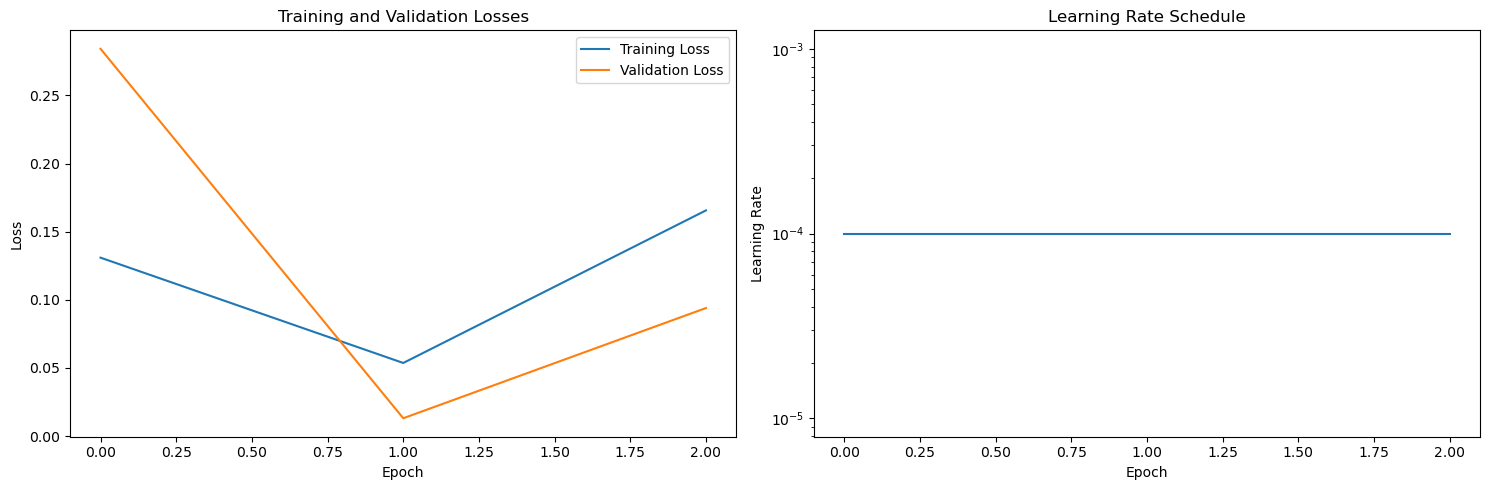


 multimodal model PoC completed!!!


In [18]:
import gc
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from datasets import load_dataset
from PIL import Image
import torchaudio
import torch.nn as nn
from sklearn.metrics import roc_curve, auc, confusion_matrix, recall_score, f1_score, precision_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
from torchvision import transforms
from timm import create_model
import os

def main():
    # Set smaller batch size and enable memory optimization
    BATCH_SIZE = 4  # Further reduced batch size
    torch.cuda.empty_cache()
    gc.collect()
    
    try:
        # Create datasets with lazy loading
        print("Loading datasets...")
        train_dataset = MultimodalDataset(split='train')
        test_dataset = MultimodalDataset(split='test')
        
        # Create dataloaders with minimal memory footprint
        train_loader = DataLoader(
            train_dataset, 
            batch_size=BATCH_SIZE, 
            shuffle=True,
            num_workers=1,  # Reduced workers
            pin_memory=False,  # Disabled pin_memory
            prefetch_factor=1
        )
        
        val_loader = DataLoader(
            test_dataset, 
            batch_size=BATCH_SIZE,
            num_workers=1,
            pin_memory=False,
            prefetch_factor=1
        )
        
        # Initialize model with memory optimization
        print("\nInitializing multimodal model...")
        model = MultimodalFakeNewsDetector()
        
        # Move model to CPU first
        model = model.cpu()
        torch.cuda.empty_cache()
        gc.collect()
        
        # Print memory status
        print("\nGPU Memory Before Loading Model:")
        print(f"Allocated: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")
        print(f"Cached: {torch.cuda.memory_reserved() / 1024**2:.2f} MB")
        
        # Move model to GPU in parts if needed
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        if torch.cuda.is_available():
            # Move individual components to GPU
            model.text_model = model.text_model.to(device)
            torch.cuda.empty_cache()
            
            model.image_model = model.image_model.to(device)
            torch.cuda.empty_cache()
            
            model.audio_model = model.audio_model.to(device)
            torch.cuda.empty_cache()
            
            model.fusion_layer = model.fusion_layer.to(device)
            torch.cuda.empty_cache()
        
        print("\nGPU Memory After Loading Model:")
        print(f"Allocated: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")
        print(f"Cached: {torch.cuda.memory_reserved() / 1024**2:.2f} MB")
        

        # Train model with memory optimization
        print("Starting training process...")
        results = train_multimodal_model(
            model=model,
            train_loader=train_loader,
            val_loader=val_loader,
            num_epochs=3,
            learning_rate=0.0001
        )

        print("Training completed. Processing results...")
        # print(f"Results type: {type(results)}")
        
        if not isinstance(results, tuple):
            raise ValueError(f"Expected tuple from train_multimodal_model, got {type(results)}")
            
        if len(results) != 3:
            raise ValueError(f"Expected 3 values, got {len(results)}")
            
        train_losses, val_losses, learning_rates = results

        print("Training completed. Processing results...")
        print(f"Number of epochs completed: {len(train_losses)}")
        print(f"Final training loss: {train_losses[-1]:.4f}")
        print(f"Final validation loss: {val_losses[-1]:.4f}")
        
        return train_losses, val_losses, learning_rates  
        
    except Exception as e:
        print(f"Error in main: {str(e)}")
        print(f"Error type: {type(e)}")
        import traceback
        traceback.print_exc()
        # Even if there's an error, return what we have
        return train_losses, val_losses, learning_rates
        
        torch.cuda.empty_cache()
        gc.collect()
        raise


if __name__ == "__main__":
    try:
        print("Starting main execution...")
        results = main()
        
        if not isinstance(results, tuple) or len(results) != 3:
            raise ValueError(f"Invalid results format: {type(results)}")
            
        train_losses, val_losses, learning_rates = results
        print("\nTraining completed successfully!")
        
        # Plot results
        plot_training_curves(train_losses, val_losses, learning_rates)
   
        
    except Exception as e:
        print(f"Fatal error: {str(e)}")
        print(f"Error type: {type(e)}")
        import traceback
        traceback.print_exc()
        torch.cuda.empty_cache()
        gc.collect()

print("\n multimodal model PoC completed!!!")

### MultiModal Model Evaluation

Loading pre-trained models...
✅ Loading BERT model...
✅ Loaded trained text model from best_bert_fake_news_detector
✅ Loading LSTM model...
✅ Loaded trained ViT model from image_model_results/best_image_model.pth
✅ Loading trained audio model
✅ Loaded trained audio model from best_lstm_fake_audio.pth
✅ Loaded trained models
Loading test datasets...
Loading text dataset...
Loading image dataset...
Loading audio dataset...
All datasets loaded successfully!
Starting evaluation...


Evaluating: 100%|██████████| 280/280 [01:19<00:00,  3.52it/s]



Model Performance Metrics:
Accuracy: 0.9982
Precision: 0.9982
Recall: 0.9982
F1 Score: 0.9982
ROC AUC: 1.0000


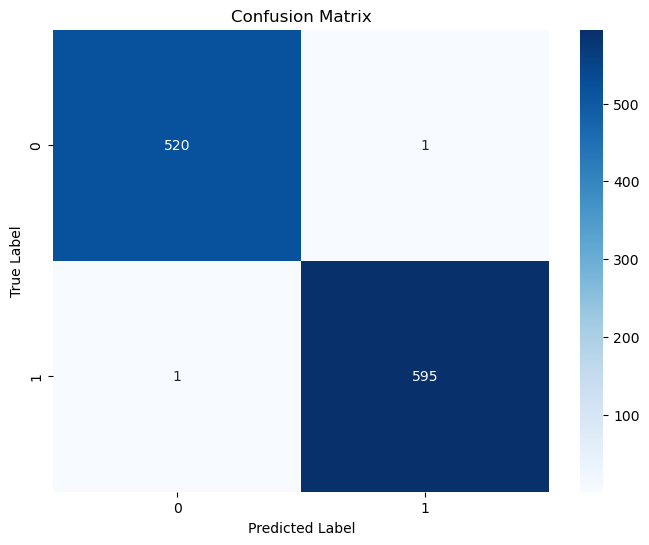

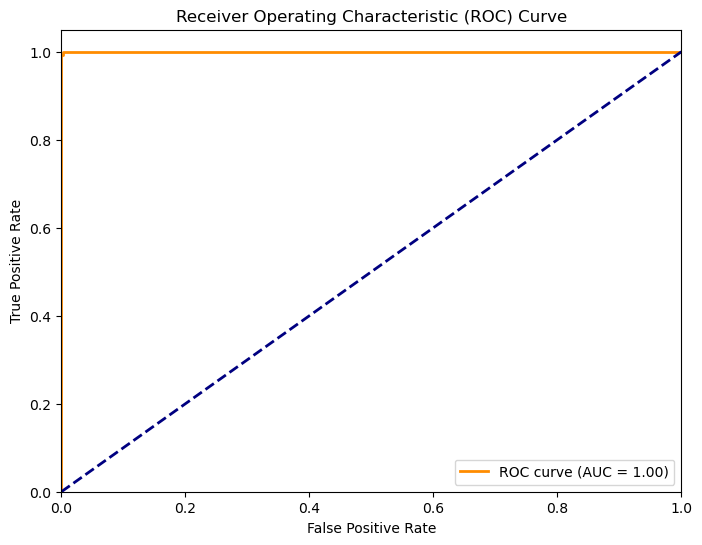


Classification Report:
              precision    recall  f1-score   support

        Fake     0.9981    0.9981    0.9981       521
        Real     0.9983    0.9983    0.9983       596

    accuracy                         0.9982      1117
   macro avg     0.9982    0.9982    0.9982      1117
weighted avg     0.9982    0.9982    0.9982      1117



In [19]:
def evaluate_multimodal_model(model, test_loader, device):
    """
    Evaluate the multimodal model's performance metrics
    """
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []
    
    print("Starting evaluation...")
    
    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Evaluating"):
            try:
                # Process text
                text_inputs = {k: v.to(device) for k, v in batch['text'].items()}
                text_outputs = model.text_model(text_inputs)
                
                # Process image
                image_inputs = batch['image'].to(device).float()
                image_inputs = image_inputs.squeeze(1)
                image_outputs = model.image_model(image_inputs)
                
                # Process audio
                audio_inputs = batch['audio'].to(device).float()
                audio_outputs = model.audio_model(audio_inputs)
                
                # Combine outputs
                combined = torch.cat((text_outputs, image_outputs, audio_outputs), dim=1)
                outputs = model.fusion_layer(combined)
                
                # Get predictions
                probs = torch.softmax(outputs, dim=1)
                preds = torch.argmax(outputs, dim=1)
                
                # Move to CPU and convert to numpy
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(batch['label'].cpu().numpy())
                all_probs.extend(probs.cpu().numpy())
                
                # Clean up memory
                del outputs, text_outputs, image_outputs, audio_outputs, combined
                torch.cuda.empty_cache()
                
            except RuntimeError as e:
                print(f"Error processing batch: {str(e)}")
                continue
    
    # Convert lists to numpy arrays
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)
    
    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')
    cm = confusion_matrix(all_labels, all_preds)
    
    # Calculate ROC curve and AUC
    fpr, tpr, _ = roc_curve(all_labels, all_probs[:, 1])
    roc_auc = auc(fpr, tpr)

    # Generate classification report
    target_names = ['Fake', 'Real']  
    report = classification_report(
        all_labels, 
        all_preds, 
        target_names=target_names,
        digits=4,
        output_dict=True
    )    
    
    # Print results
    print("\nModel Performance Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

    # Print detailed report
    print("\nClassification Report:")
    print("=====================")
    print(classification_report(all_labels, all_preds, target_names=target_names, digits=4))
    
   
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'confusion_matrix': cm,
        'roc_auc': roc_auc,
        'predictions': all_preds,
        'probabilities': all_probs
    }

# Usage example:
def main():
    # Initialize your model and test_loader here
    model = MultimodalFakeNewsDetector()
    test_dataset = MultimodalDataset(split='test')
    test_loader = DataLoader(
        test_dataset,
        batch_size=4,
        shuffle=False,
        num_workers=1,
        pin_memory=False
    )
    
    # Load the best model weights
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    checkpoint = torch.load('best_multimodal_model.pth', map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    
    # Evaluate the model
    results = evaluate_multimodal_model(model, test_loader, device)
    
    # Save results to file
    with open('multimodal_evaluation_results.txt', 'w') as f:
        f.write("Multimodal Model Evaluation Results\n")
        f.write("==================================\n")
        f.write(f"📊 Accuracy: {results['accuracy']:.4f}\n")
        f.write(f"📊 Precision: {results['precision']:.4f}\n")
        f.write(f"📊 Recall: {results['recall']:.4f}\n")
        f.write(f"📊 F1 Score: {results['f1']:.4f}\n")
        f.write(f"📊 ROC AUC: {results['roc_auc']:.4f}\n")

        
    return train_losses, val_losses, learning_rates

if __name__ == "__main__":
    main()
